In [1]:
from collections import defaultdict
import random
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab20")
colors = sns.color_palette("bright")

import time 
import multiprocessing

from algos import *
from bandit_problem import *

In [7]:
manager = multiprocessing.Manager()
error_list = manager.list()

def run_trial(
        i_trial, bandit_problem, estimator, num_actions, num_samples, args):
    
    random.seed(10000 + i_trial)
    np.random.seed(10000 + i_trial)
    
    # generate rewards
    action_rewards = bandit_problem.get_rewards(num_samples)
    
    # action_mus_hat = np.mean(action_rewards, axis=0)
    # action_sigmas_hat = np.std(action_rewards, axis=0, ddof=1)
    # print(action_mus_hat)
    # print(action_sigmas_hat)
    # stop
    
    # apply estimator
    mu_est = estimator(action_rewards, num_actions, num_samples, args)    
    # print(mu_est)

    mu_max = np.max(bandit_problem.action_mus)
    # print(mu_max)
    error_list.append(mu_est - mu_max)    

# params
num_actions = 4
num_samples = 50
num_trials = 200

bandit_args = dict() 
reward_dist = "normal"
problem_instance = "multi_gap_nonlinear"
action_sigmas = np.ones(num_actions)
gap_splits = [0.5]
gap_deltas = [10.0]
bandit_problem = BanditProblem(
            problem_instance, reward_dist, num_actions, action_sigmas=action_sigmas,
            gap_splits=gap_splits, gap_deltas=gap_deltas)

# print(f"action_mus = {bandit_problem.action_mus}")
# print(f"action_sigmas = {bandit_problem.action_sigmas}")

args = dict()
args["weightedms_num_data"] = 1000
args["haver_alpha"] = 2.0
args["haver_delta"] = 0.05
args["haver_const"] = 1.0
    
pool = multiprocessing.Pool()

# sigma_ary = [10, 100, 500, 1000, 4000, 6000, 8000, 10000]
sigma_ary = [1.0, 2.0,  4.0, 6.0, 8.0, 10.0] 

est_bias_dict = defaultdict(lambda: np.zeros(len(sigma_ary)))
est_var_dict = defaultdict(lambda: np.zeros(len(sigma_ary)))
est_mse_dict = defaultdict(lambda: np.zeros(len(sigma_ary)))

haver_const_ary = [1.0, 1.5, 2.0] 
haver_name_ary = [f"haver_{x}" for x in haver_const_ary]
est_name_ary = ["weightedms", "double", "max"]
est_name_ary += haver_name_ary
for est_name in est_name_ary:
    start_time = time.time()
    print(f"\n-> est_name = {est_name}")
    if "haver" in est_name:
        estimator = create_estimator("haver")
        haver_const = float(est_name.split("_")[-1])
        args["haver_const"] = haver_const
        print(f"haver_const = {haver_const}")
    else:
        estimator = create_estimator(est_name)        
        
    for i_s, sigma in enumerate(sigma_ary):
        action_sigmas = sigma*np.ones(num_actions)
        bandit_problem = BanditProblem(
            problem_instance, reward_dist, num_actions, action_sigmas=action_sigmas,
            gap_splits=gap_splits, gap_deltas=gap_deltas)
        
        trial_args = [
            (i, bandit_problem, estimator, num_actions, num_samples, args) for i in range(num_trials)]
        pool.starmap(run_trial, trial_args)

        error_ary = np.hstack(error_list)
        est_bias = np.mean(error_ary)
        est_var = np.var(error_ary, ddof=1)
        est_mse = est_bias**2 + est_var

        est_bias_dict[est_name][i_s] = est_bias
        est_var_dict[est_name][i_s] = est_var
        est_mse_dict[est_name][i_s] = est_mse

        error_list[:] = []
        
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")
    



-> est_name = weightedms
it takes 0.1378

-> est_name = double
it takes 0.1141

-> est_name = max
it takes 0.1132

-> est_name = haver_1.0
haver_const = 1.0
it takes 0.1168

-> est_name = haver_1.5
haver_const = 1.5
it takes 0.1165

-> est_name = haver_2.0
haver_const = 2.0
it takes 0.1190


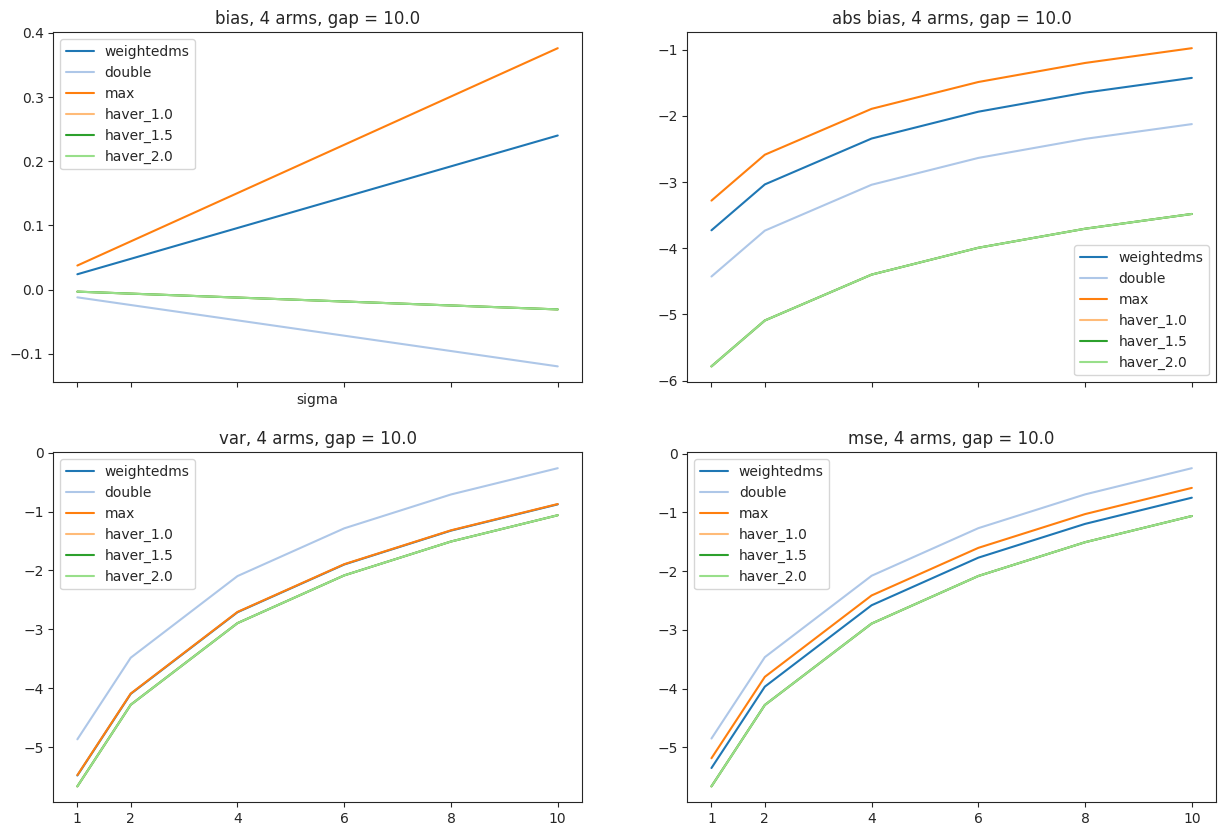

In [9]:
fig, axes = fig, axes = plt.subplots(
    nrows=2, ncols=2, sharex=True, sharey=False, figsize=(15,10))
# axes = [axes]
axes = axes.ravel()

x_ary = sigma_ary
for est_name in est_name_ary:
    axes[0].plot(x_ary, est_bias_dict[est_name], label=est_name)
    # axes[1].plot(x_ary, np.abs(est_bias_dict[est_name]), label=est_name)
    # axes[2].plot(x_ary, est_var_dict[est_name], label=est_name)
    # axes[3].plot(x_ary, est_mse_dict[est_name], label=est_name)
    # axes[0].plot(x_ary, np.log(est_bias_dict[est_name]), label=est_name)
    axes[1].plot(x_ary, np.log(np.abs(est_bias_dict[est_name])), label=est_name)
    axes[2].plot(x_ary, np.log(est_var_dict[est_name]), label=est_name)
    axes[3].plot(x_ary, np.log(est_mse_dict[est_name]), label=est_name)
    
axes[0].set_xticks(x_ary)
axes[0].set_xlabel("sigma")
axes[0].set_title(f"bias, {num_actions} arms, gap = {gap_deltas[-1]}")
axes[1].set_title(f"abs bias, {num_actions} arms, gap = {gap_deltas[-1]}")
axes[2].set_title(f"var, {num_actions} arms, gap = {gap_deltas[-1]}")
axes[3].set_title(f"mse, {num_actions} arms, gap = {gap_deltas[-1]}")
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.show()
